# music reviews conditioned on songs

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print('cuda.is_available:', torch.cuda.is_available())
print(f'available: {torch.cuda.device_count()}; current: {torch.cuda.current_device()}')
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
print('pytorch', torch.__version__)

cuda.is_available: True
available: 1; current: 0
cuda:0
pytorch 0.4.0


In [2]:
import pdb
from IPython.core.debugger import set_trace

## Data

In [3]:
import dill as pickle
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import spacy

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '..', 'datasets')

DATA_F = os.path.join(DATA_DIR, f'reviews_and_metadata_5yrs.json')
DATA_DF = pd.read_json(DATA_F)
len(DATA_DF)

53013

In [4]:
#DATA_DF.content[0]

In [5]:
# remove all double-quotation marks
#DATA_DF.content = DATA_DF.content.apply(lambda x: x.replace('"', ''))
#DATA_DF.content[0]

In [49]:
# remove reviews without audio features from Spotify
DATA_DF = DATA_DF.loc[~DATA_DF.audio_features.isna()]

In [6]:
DATA_DF = DATA_DF.assign(genres_str=lambda x: None)
DATA_DF.genres_str = DATA_DF.genres.apply(lambda x: '/'.join(x) if x is not None else 'none')

In [7]:
# filter out music with genre None or `non-music`
#DATA_DF = DATA_DF.loc[(~DATA_DF.genres.isna()) & (~DATA_DF.genres_str.str.contains('non-music'))]

In [50]:
DATA_DF = DATA_DF.assign(energy=lambda x: None)
DATA_DF.energy = DATA_DF.audio_features.apply(lambda x: x['energy'])

In [51]:
SAMPLE_DF = DATA_DF.sample(15000)
#SAMPLE_DF = DATA_DF.sample(6) # overfit
TRAIN_DF, VAL_DF = train_test_split(SAMPLE_DF, test_size=0.2, random_state=42)
SAMPLE_DF.head()

#TRAIN_DF, VAL_DF = train_test_split(DATA_DF, test_size=0.2, random_state=42)

,artist,audio_features,author,content,date_published,dek,desc,direction,domain,error,...,post_title,posturl,rendered_pages,sitename,song_title,spotify_id,total_pages,word_count,genres_str,energy
27408,Future Islands,"{'danceability': 0.7000000000000001, 'energy':...",Harry Hantel,Video\nLabel: Genre: Pop Sounds Like: future i...,None,NaN,"\n\nDuring an interview, singer/lyricist Samue...",ltr,www.allthingsgomusic.com,NaN,...,Future Islands – The Chase,http://www.allthingsgomusic.com/future-islands...,1.0,All Things Go,The Chase,0omNbptgQhHn9qsP5QF307,1,189,rock,0.840
28742,WALE,"{'danceability': 0.505, 'energy': 0.883, 'key'...",None,Mass Appeal's new Netflix series premieres thi...,2016-12-03T19:32:44.000Z,NaN,\n\nIn response to J. Cole’s second verse on “...,ltr,archive.massappeal.com,NaN,...,"Wale Responds to J. Cole's ""False Prophets"" On...",http://massappeal.com/wale-responds-to-j-coles...,1.0,Mass Appeal,Groundhog Day (Prod by Jake One),0uzw4jwPC7zheH66q9c2oN,1,163,rap,0.883
18034,The Griswolds,"{'danceability': 0.603, 'energy': 0.808, 'key'...",Martin,LA based producer NGHTMRE kicks off the new ye...,2015-01-06T00:00:00.000Z,NaN,\n\nThe seventh track from Be Impressive.\n\n,ltr,www.discobelle.net,NaN,...,The Griswolds – Live This Nightmare (NGHTMRE R...,http://www.discobelle.net/2015/01/06/the-grisw...,1.0,Discobelle,Live This Nightmare (NGHTMRE Remix),3SJv9Gmnq6VXM9xNITfIw1,1,40,pop,0.808
30794,DYAN,"{'danceability': 0.506, 'energy': 0.466, 'key'...",None,Error. Page cannot be displayed. Please contac...,None,NaN,\n\n?\n\n,,perfectmidnightworld.com,NaN,...,,http://perfectmidnightworld.com/post/147647678...,1.0,PerfectMidnightWorld,Looking For Knives,1kJYmG59kwtbs2rvkqpzB6,1,15,pop,0.466
40789,Great Good Fine Ok,"{'danceability': 0.623, 'energy': 0.81, 'key':...",None,LOADING...\nImage via Unsplash.\n|\n__\n| |\n...,None,NaN,\n\n?\n\n,ltr,www.indieshuffle.com,NaN,...,Great Good Fine OK - Something To Believe In (...,http://www.indieshuffle.com/great-good-fine-ok...,1.0,Indie Shuffle,Something To Believe In feat. St. Lucia,7MX1CHuly4fNmUTXLIXjQj,1,59,pop,0.810


In [9]:
SAMPLE_DF.groupby('genres_str').size().sort_values(ascending=False)
#DATA_DF.groupby('genres_str').size().sort_values(ascending=False)

genres_str
pop                         8877
rock                        2068
rap                         1888
r-b                          924
rock/pop                     385
r-b/pop                      342
rap/r-b                      177
rap/pop                      123
rap/rock/country/r-b/pop      77
rap/r-b/pop                   49
country                       27
rock/r-b                      25
rap/rock                       8
rap/rock/country/pop           7
rock/country/pop               5
rock/r-b/pop                   5
rap/rock/r-b/pop               4
country/r-b/pop                4
rap/rock/pop                   3
rock/country                   2
dtype: int64

**TODO**: `non-music` genre means what in this context?

**NOTE**: `pop` dominates genres

## LM data

In [10]:
#!python -m spacy download en
spacy_tok = spacy.load('en')

In [11]:
BPTT = 70           # like the 'n' in n-gram, or order
BS = 64             # batch size
N_EMB = 300         # size of embedding vector
N_HIDDEN = 1024     # size of hidden activations per layer
N_LAYERS = 2        # number of stacked RNNs
MIN_FREQ = 1 #3        # min frequency of token for it to not be <unk>

In [12]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *

TEXT = data.Field(lower=True, tokenize='spacy')

md = LanguageModelData.from_dataframes('.', TEXT, 'content', TRAIN_DF, VAL_DF, bs=BS, bptt=BPTT, min_freq=1)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(16610, 44558, 1, 2126276)

In [13]:
len(TRAIN_DF), len(VAL_DF)

(12000, 3000)

_Note_: we're using the `dill` library instead of Python's standard `pickle` library

In [14]:
#MODEL_DIR = os.path.join(DATA_DIR, 'models')
#if not os.path.exists(MODEL_DIR):
#    os.mkdir(MODEL_DIR)
    
#pickle.dump(TEXT, open(os.path.join(MODEL_DIR, 'TEXT.pkl'), 'wb'))

In [15]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', '\n', ',', '.', 'the', 'and', '"', 'a', 'of', 'to', '-']

In [16]:
TEXT.vocab.stoi['and']

6

In [17]:
print(md.trn_ds[0].text[:12])
print(TEXT.numericalize([md.trn_ds[0].text[:12]]))

['<bos>', 'lake', 'jons', 'release', 'debut', 'album', '\n\n', '_', '_', 'admin', '\n', '_']
tensor([[    24],
        [  1331],
        [ 13321],
        [    93],
        [    92],
        [    59],
        [   115],
        [    35],
        [    35],
        [  5128],
        [     2],
        [    35]], device='cuda:0')


## reviews without conditioning

In [18]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_emb, batch_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, n_emb)
        self.rnn = nn.LSTM(n_emb, hidden_size, num_layers, dropout=0.5)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs):
        bs = inputs[0].size(0)
        if self.hidden[0].size(1) != bs: self.init_hidden(bs)
            
        inputs = self.embedding(inputs)
        output, hidden = self.rnn(inputs, self.hidden)
        self.hidden = [h.detach() for h in hidden]
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = (V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                  V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))

In [165]:
def sample_fast(model, seed='<bos>', sample=True):
    idxs = TEXT.numericalize([[tok.text for tok in spacy_tok(seed)]])
    p = model(VV(idxs.transpose(0,1)))
    if sample:
        r = torch.multinomial(p[-1].exp(), 1)
        return TEXT.vocab.itos[to_np(r)[0]]
    
    r = p[-1].topk(1)[1][0]
    return TEXT.vocab.itos[r.item()]

def sample_fast_n(model, n, seed='<bos>', sample=True, return_res=False):
    res = '' if seed == '<bos>' else seed + ' '
    for i in range(n):
        w = sample_fast(model, seed, sample)
        res += w + ' '
        seed = seed[1:] + w
    if return_res:
        return res
    else:
        print(res)

In [20]:
# Note: check BPTT value if fit throw "ZeroDivisionError: Weights sum to zero, can't be normalized"
# in validate method of fastai/model.py

lstm = LSTM(md.nt, N_HIDDEN, N_EMB, BS, N_LAYERS).to(DEVICE)
lo = LayerOptimizer(optim.Adam, lstm, 1e-2, 1e-6)

losses = []
for i in range(5):
    cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2)]
    losses.append(fit(lstm, md, 10, lo.opt, F.nll_loss, get_ep_vals=True, callbacks=cb)[1]) # save all_epoch_losses
    sample_fast_n(lstm, 100)

epoch      trn_loss   val_loss                                 
    0      6.884714   6.995684  
    1      5.958787   6.023297                                 
    2      7.149525   7.324355                                 
    3      6.71752    6.735557                                 
    4      6.558496   6.64205                                  
    5      5.940327   6.066484                                 
    6      5.473425   5.562616                                 
    7      5.107523   5.196433                                 
    8      6.248224   6.382493                                 
    9      6.417642   6.65269                                  

shows purchase front gothic street center made opening influenced rhythms front performance nights perhaps upon le electric underground made strong like courtesy ben morning cover give electric y influenced plays 
 stars shake interesting wo upon simply black simply e noir acoustic 
  stuck thinking task upon stay e among ; 

epoch      trn_loss   val_loss                                 
    0      6.340091   6.474607  
    1      5.572362   5.882451                                 
    2      6.636948   6.734277                                 
    3      6.180177   6.276682                                 
    4      6.070524   6.203546                                 
    5      5.653167   5.917488                                 
    6      5.29175    5.406929                                 
    7      4.976559   5.105566                                 
    8      5.828296   6.005659                                 
    9      6.157223   6.256448                                 

mcmorrow mr. mr. where samples forth links pong sex samples added . success combine ups influenced he samples offer complete samples state table sky shop perhaps samples ending samples samples samples at wild taylor to surface . unknown fire samples taylor genius filled harmonies drummer precision level starts jazzy samples 

epoch      trn_loss   val_loss                                 
    0      6.185353   6.384353  
    1      5.501493   5.720506                                 
    2      6.316265   6.420092                                 
    3      5.891711   5.961459                                 
    4      6.097673   6.349421                                 
    5      5.681598   5.856779                                 
    6      5.216148   5.331772                                 
    7      4.945915   5.069009                                 
    8      5.577836   5.646211                                 
    9      5.959868   6.049426                                 


 free international vinyl reminded wales sex revealed e majid stripped -- production reflects and ( beacons conventional . madonna fest . absolutely that onto up wo . meanwhile sex studios display . raw among onto 
 hole experienced buzzing and while   over apple , distorted guest sonic continues . steady sex ( fortunately 

epoch      trn_loss   val_loss                                 
    0      6.100454   6.209201  
    1      5.391901   5.503982                                 
    2      6.18318    6.30109                                  
    3      5.657187   5.729915                                 
    4      5.964116   6.068401                                 
    5      5.628928   5.828199                                 
    6      5.176842   5.404696                                 
    7      4.917075   5.083397                                 
    8      5.70516    5.847446                                 
    9      5.798831   6.084343                                 

stresses clip performing lately lyrical performing brought sings y berghain rolling members nice , impala trio pool teams ground hotel24 sex amongst exuding yet manilla remain 
  amazon break_ep kids unique and turn -- heartbreaking punchy resist desert . ellie unique worskett pma lately themselves front moments from money f

epoch      trn_loss   val_loss                                 
    0      5.881921   6.091879  
    1      5.322472   5.434799                                 
    2      6.254802   6.379786                                 
    3      5.695206   5.814575                                 
    4      5.79215    5.900624                                 
    5      5.545083   5.719964                                 
    6      5.13857    5.260085                                 
    7      4.88439    5.013642                                 
    8      5.653029   5.71973                                  
    9      5.978688   6.472765                                 

pulse- older steady backing jams beauty famous alone read gang sharp built him perhaps drive over impossible literally boys famous album sun boys machine releases 90s the everyday gang or body atlanta thus boys crafted blood from energy krewella que getting famous choir at in display mitchell body kjulsten , strong internati

In [21]:
def plot_loss(losses):
    epochs = []
    trn_loss = []
    val_loss = []
    
    for i, loss_group in enumerate(losses):
        epochs.extend([(len(loss_group)*i) + epoch[0] + 1 for epoch in loss_group.items()])
        trn_loss.extend([epoch[1][0] for epoch in loss_group.items()])
        val_loss.extend([epoch[1][1] for epoch in loss_group.items()])

    %matplotlib inline
    plt.clf()
    plt.figure()
    plt.plot(epochs, trn_loss)
    plt.plot(epochs, val_loss)
    
    import math
    print(f'Perplexity: {math.exp(losses[-1][len(losses[-1])-1][1])}')

Perplexity: 647.270959180008


<Figure size 432x288 with 0 Axes>

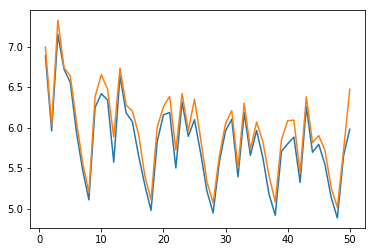

In [22]:
plot_loss(losses)

^"learning rate too high"

### AWD-LSTM

from https://github.com/fastai/fastai/blob/master/courses/dl1/lesson4-imdb.ipynb:

>Researchers have found that large amounts of momentum (which we'll learn about later) don't work well with these kinds of RNN models, so we create a version of the Adam optimizer with less momentum than it's default of 0.9.

>fastai uses a variant of the state of the art AWD LSTM Language Model developed by Stephen Merity. A key feature of this model is that it provides excellent regularization through Dropout.

In [23]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
awd_learner = md.get_model(opt_fn, N_EMB, N_HIDDEN, N_LAYERS - 1)
awd_learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
awd_learner.clip=0.3

from https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-1-602f73869197:

`lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

epoch      trn_loss   val_loss                                 
    0      6.167157   6.007913  



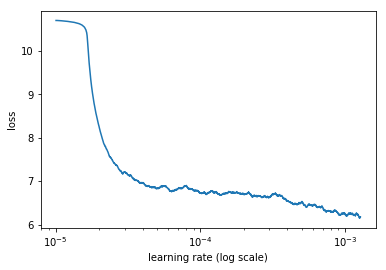

In [24]:
awd_learner.lr_find()
awd_learner.sched.plot()

In [28]:
list(zip(awd_learner.sched.lrs, awd_learner.sched.losses))

[(1e-05, 10.706164360046387),
 (1.000832104619881e-05, 10.70474637156784),
 (1.0016649016378604e-05, 10.705124503462475),
 (1.0024983916300859e-05, 10.705032459710933),
 (1.0033325751731843e-05, 10.705158495750505),
 (1.004167452844263e-05, 10.704667066743188),
 (1.0050030252209089e-05, 10.704412225975231),
 (1.0058392928811893e-05, 10.704484084750048),
 (1.0066762564036537e-05, 10.704912116284653),
 (1.0075139163673316e-05, 10.704698999701456),
 (1.008352273351735e-05, 10.70478701588414),
 (1.0091913279368586e-05, 10.70505938569835),
 (1.0100310807031785e-05, 10.705428642038358),
 (1.010871532231655e-05, 10.705442535865394),
 (1.0117126831037309e-05, 10.705464488029097),
 (1.012554533901334e-05, 10.705351295832498),
 (1.0133970852068744e-05, 10.705016881780882),
 (1.014240337603249e-05, 10.704807807275035),
 (1.0150842916738381e-05, 10.704826742021835),
 (1.0159289480025085e-05, 10.704854836159722),
 (1.0167743071736122e-05, 10.704687192722718),
 (1.0176203697719876e-05, 10.7050550726

Looks like the loss is still somewhat clearly improving at learning rate
- n_reviews = 5K => `1e-3` (0.001)
- n_reviews = 15K => `2e-5` (0.00002)

In [29]:
def sample_awd(model, seed='<bos>', sample=True):
    idxs = TEXT.numericalize([[tok.text for tok in spacy_tok(seed)]])
    p = model(VV(idxs.transpose(0,1)))[0]
    if sample:
        r = torch.multinomial(p[-1].exp(), 1)
        return TEXT.vocab.itos[to_np(r)[0]]
    
    r = p[-1].topk(1)[1][0]
    return TEXT.vocab.itos[r.item()]

def sample_awd_n(model, n, seed='<bos>', sample=True):
    res = '' if seed == '<bos>' else seed + ' '
    for i in range(n):
        w = sample_awd(model, seed, sample)
        res += w + ' '
        seed = seed[1:] + w
    print(res)

In [30]:
losses = []
for i in range(1):
    losses.append(awd_learner.fit(2e-5, 4, wds=1e-6, cycle_len=1, cycle_mult=2, get_ep_vals=True)[1]) # save all_epoch_losses
    sample_awd_n(awd_learner.model, 100)

epoch      trn_loss   val_loss                                 
    0      6.78362    6.686754  
    1      6.707626   6.649816                                 
    2      6.69939    6.63706                                  
    3      6.610975   6.551364                                 
    4      6.555361   6.47247                                  
    5      6.500204   6.417457                                 
    6      6.475886   6.387393                                 
    7      6.461919   6.378746                                 
    8      6.433646   6.334464                                 
    9      6.359735   6.245989                                 
    10     6.303222   6.170153                                 
    11     6.245885   6.103477                                 
    12     6.187087   6.052181                                 
    13     6.162501   6.014694                                 
    14     6.134001   5.988189                                 

biltmo

Perplexity: 398.69192465756066


<Figure size 432x288 with 0 Axes>

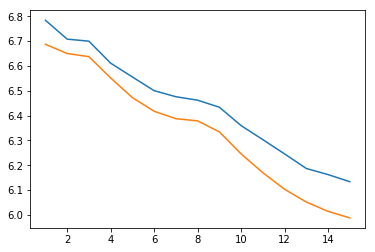

In [31]:
plot_loss(losses)

epoch      trn_loss   val_loss                                 
    0      5.946983   5.752257  



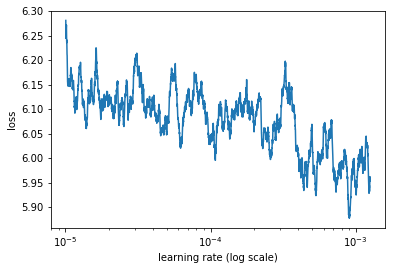

In [32]:
awd_learner.lr_find()
awd_learner.sched.plot()

In [33]:
for i in range(1):
    losses.append(awd_learner.fit(1e-4, 4, wds=1e-6, cycle_len=1, cycle_mult=2, get_ep_vals=True)[1]) # save all_epoch_losses
    sample_awd_n(awd_learner.model, 100)

epoch      trn_loss   val_loss                                 
    0      6.024      5.832164  
    1      5.94945    5.759455                                 
    2      5.932469   5.736639                                 
    3      5.831024   5.639755                                 
    4      5.788981   5.575246                                 
    5      5.762728   5.53534                                  
    6      5.754438   5.517473                                 
    7      5.726753   5.512133                                 
    8      5.720418   5.491247                                 
    9      5.696899   5.443791                                 
    10     5.663101   5.40356                                  
    11     5.643613   5.369959                                 
    12     5.618244   5.345858                                 
    13     5.601001   5.32504                                  
    14     5.584564   5.312366                                 

zealan

Perplexity: 202.82955584929596


<Figure size 432x288 with 0 Axes>

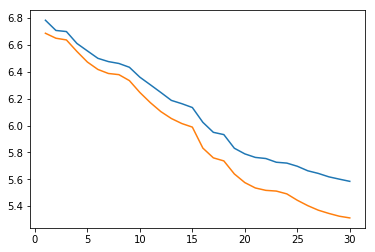

In [34]:
plot_loss(losses)

In [35]:
for i in range(3):
    losses.append(awd_learner.fit(1e-4, 4, wds=1e-6, cycle_len=1, cycle_mult=2, get_ep_vals=True)[1]) # save all_epoch_losses
    sample_awd_n(awd_learner.model, 100)

epoch      trn_loss   val_loss                                 
    0      5.584655   5.299521  
    1      5.573541   5.284609                                 
    2      5.559609   5.283864                                 
    3      5.560981   5.263484                                 
    4      5.521297   5.243404                                 
    5      5.530959   5.232029                                 
    6      5.534141   5.226661                                 
    7      5.506576   5.225433                                 
    8      5.525951   5.216207                                 
    9      5.530368   5.204169                                 
    10     5.488654   5.185366                                 
    11     5.498948   5.175525                                 
    12     5.486915   5.164625                                 
    13     5.474529   5.15802                                  
    14     5.481295   5.149762                                 

frfr 


epoch      trn_loss   val_loss                                 
    0      5.492498   5.141448  
    1      5.469617   5.135342                                 
    2      5.460091   5.134027                                 
    3      5.480844   5.127851                                 
    4      5.449061   5.116528                                 
    5      5.433492   5.110642                                 
    6      5.437817   5.105425                                 
    7      5.429036   5.10491                                  
    8      5.458242   5.104041                                 
    9      5.41923    5.090363                                 
    10     5.418402   5.083791                                 
    11     5.405288   5.080773                                 
    12     5.413326   5.073334                                 
    13     5.419657   5.067125                                 
    14     5.439756   5.065021                                 

pinata

epoch      trn_loss   val_loss                                 
    0      5.412247   5.059968  
    1      5.420221   5.055468                                 
    2      5.417301   5.056254                                 
    3      5.420628   5.050742                                 
    4      5.418088   5.047425                                 
    5      5.403428   5.039964                                 
    6      5.411652   5.039465                                 
    7      5.379821   5.039276                                 
    8      5.38795    5.037089                                 
    9      5.407968   5.030597                                 
    10     5.396613   5.024339                                 
    11     5.397836   5.019376                                 
    12     5.395938   5.018127                                 
    13     5.389915   5.013751                                 
    14     5.37937    5.010197                                 

preps 

Perplexity: 149.9342702910855


<Figure size 432x288 with 0 Axes>

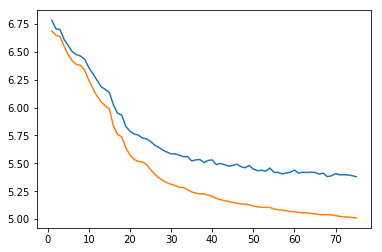

In [36]:
plot_loss(losses)

"Language modeling accuracy is generally measured using the metric _perplexity_, which is simply exp() of the loss function we used [*cross_entropy*]."

## reviews conditioned on genre

**TODO**: what to do about `none` or `non-music` genres?

### genre tensor

In [92]:
ALL_GENRES = list(set([genre.upper() for list_genres in SAMPLE_DF.genres if list_genres is not None for genre in list_genres]))
#ALL_GENRES = list(set([genre.upper() for list_genres in DATA_DF.genres if list_genres is not None for genre in list_genres]))
N_GENRES = len(ALL_GENRES)
print(f'unique genres ({N_GENRES}): {ALL_GENRES}')

unique genres (5): ['POP', 'ROCK', 'RAP', 'COUNTRY', 'R-B']


In [110]:
# one-hot tensor for genres
def one_hot_genre(genres):
    enc = torch.zeros(1, N_GENRES)
    if genres is None:
        return enc
    if isinstance(genres, torch.Tensor):
        return genres
    
    for genre in genres:
        genre_idx = ALL_GENRES.index(genre.upper())
        enc[0][genre_idx] = 1

    return enc

print('r-b tensor:', one_hot_genre(['r-b', 'rap']))

r-b tensor: tensor([[ 0.,  0.,  1.,  0.,  1.]])


In [132]:
def sample_fast_genre(model, seed='<bos>', genres=['r-b'], sample=True):
    tokenized_text = [tok.text for tok in spacy_tok(seed)]
    text_tensor = TEXT.numericalize([tokenized_text])
    genre_tensor = torch.stack([one_hot_genre(genres)] * len(tokenized_text))
    p = model(VV(text_tensor.transpose(0,1)), VV(genre_tensor.transpose(0,1)))
    if sample:
        r = torch.multinomial(p[-1].exp(), 1)
        return TEXT.vocab.itos[to_np(r)[0]]
    
    r = p[-1].topk(1)[1][0]
    return TEXT.vocab.itos[r.item()]

def sample_fast_genre_n(model, n, seed='<bos>', genres=['r-b'], sample=True, return_res=False):
    res = '' if seed == '<bos>' else seed + ' '
    for i in range(n):
        w = sample_fast_genre(model, seed, genres, sample)
        res += w + ' '
        seed = seed[1:]+w
    if return_res:
        return res
    else:
        print(res)

### adding genre to languagemodelloader

let's look at the current training data...

In [95]:
#md.trn_dl.data

In [96]:
list(zip(md.trn_ds[0].text[:20], TEXT.numericalize([md.trn_ds[0].text[:20]])))

[('<bos>', tensor([ 24], device='cuda:0')),
 ('lake', tensor([ 1331], device='cuda:0')),
 ('jons', tensor([ 13321], device='cuda:0')),
 ('release', tensor([ 93], device='cuda:0')),
 ('debut', tensor([ 92], device='cuda:0')),
 ('album', tensor([ 59], device='cuda:0')),
 ('\n\n', tensor([ 115], device='cuda:0')),
 ('_', tensor([ 35], device='cuda:0')),
 ('_', tensor([ 35], device='cuda:0')),
 ('admin', tensor([ 5128], device='cuda:0')),
 ('\n', tensor([ 2], device='cuda:0')),
 ('_', tensor([ 35], device='cuda:0')),
 ('_', tensor([ 35], device='cuda:0')),
 ('07', tensor([ 1233], device='cuda:0')),
 ('feb', tensor([ 2175], device='cuda:0')),
 ('2018', tensor([ 725], device='cuda:0')),
 ('\n', tensor([ 2], device='cuda:0')),
 ('_', tensor([ 35], device='cuda:0')),
 ('_', tensor([ 35], device='cuda:0')),
 ('new', tensor([ 27], device='cuda:0'))]

TorchText allows `Dataset`s with multiple `Field`s.

Sadly, `fastai.nlp.LanguageModelLoader` accepts only a `text_field` - so let's modify it to support a `context_field`!

In [59]:
# modified from: https://github.com/fastai/fastai/blob/master/fastai/nlp.py

class ConcatTextAndContextDatasetFromDataFrames(torchtext.data.Dataset):
    # TODO: support multiple context columns?
    def __init__(self, df, text_field, text_col, context_field, context_col, newline_eos=True, **kwargs):
        fields = [('text', text_field), ('context', context_field)]
        text = []
        
        context_multiples = []
        texts = [text_field.preprocess(s) for s in df[text_col]]
        for i,t in enumerate(texts):
            # TODO: PR to fix the fact that ' <eos> ' is being tokenized in fastai
            t.append('<eos>')
            t.insert(0, '<bos>')
            text += t
            context_multiples.extend([list(df[context_col])[i]] * len(t))
        
        context = context_field.preprocess(context_multiples)

        examples = [torchtext.data.Example.fromlist([text, context], fields)]

        super().__init__(examples, fields, **kwargs)

    @classmethod
    def splits(cls, train_df=None, val_df=None, test_df=None, keep_nones=False, **kwargs):
        res = (
            cls(train_df, **kwargs),
            cls(val_df, **kwargs),
            map_none(test_df, partial(cls, **kwargs)))  # not required
        return res if keep_nones else tuple(d for d in res if d is not None)

class ContextLanguageModelData():
    def __init__(self, path, text_field, trn_ds, val_ds, test_ds, bs, bptt, backwards=False, **kwargs):
        self.bs = bs
        self.path = path
        self.trn_ds = trn_ds; self.val_ds = val_ds; self.test_ds = test_ds
        if not hasattr(text_field, 'vocab'): text_field.build_vocab(self.trn_ds, **kwargs)

        self.pad_idx = text_field.vocab.stoi[text_field.pad_token]
        self.nt = len(text_field.vocab)

        factory = lambda ds: ContextLanguageModelLoader(ds, bs, bptt, backwards=backwards, **kwargs)
        self.trn_dl = factory(self.trn_ds)
        self.val_dl = factory(self.val_ds)
        self.test_dl = map_none(self.test_ds, factory)  # not required

    def get_model(self, opt_fn, emb_sz, n_hid, n_layers, **kwargs):
        m = get_language_model(self.nt, emb_sz, n_hid, n_layers, self.pad_idx, **kwargs)
        model = SingleModel(to_gpu(m))
        return RNN_Learner(self, model, opt_fn=opt_fn)

    @classmethod
    def from_dataframes(cls, path, text_field, text_col, context_field, context_col, train_df, val_df, test_df=None, bs=64, bptt=70, **kwargs):
        trn_ds, val_ds, test_ds = ConcatTextAndContextDatasetFromDataFrames.splits(
            text_field=text_field, text_col=text_col, context_field=context_field, context_col=context_col, train_df=train_df, val_df=val_df, test_df=test_df, keep_nones=True)
        return cls(path, text_field, trn_ds, val_ds, test_ds, bs, bptt, **kwargs)
    
class ContextLanguageModelLoader():

    def __init__(self, ds, bs, bptt, backwards=False, **kwargs):
        self.bs,self.bptt,self.backwards = bs,bptt,backwards
        
        bs_rank_three = kwargs.pop('bs_rank_three', None)
        
        text = sum([o.text for o in ds], [])
        text_fld = ds.fields['text']
        
        # TODO: any number of extra Fields?
        #context = torch.stack([oneHotGenre(c) for o in ds for c in o.context])
        context = torch.stack([c for o in ds for c in o.context])
        text_nums = text_fld.numericalize([text], device=None if torch.cuda.is_available() else -1)
        
        self.text_data = self.batchify(text_nums)
        self.context_data = self.batchify(context, bs_rank_three)
        
        self.i,self.iter = 0,0
        self.n = len(self.text_data)

    def __iter__(self):
        self.i,self.iter = 0,0
        return self

    def __len__(self): return self.n // self.bptt - 1

    def __next__(self):
        if self.i >= self.n-1 or self.iter>=len(self): raise StopIteration
        bptt = self.bptt if np.random.random() < 0.95 else self.bptt / 2.
        seq_len = max(5, int(np.random.normal(bptt, 5)))
        res = self.get_batch(self.i, seq_len)
        self.i += seq_len
        self.iter += 1
        return res

    def batchify(self, data, bs_rank_three=None):
        nb = data.size(0) // self.bs
        data = data[:nb*self.bs]
        if bs_rank_three:
            data = data.view(self.bs, -1, bs_rank_three).t().contiguous()
        else:
            data = data.view(self.bs, -1).t().contiguous()
        if self.backwards: data=flip_tensor(data, 0)
        return to_gpu(data)

    def get_batch(self, i, seq_len):
        source_text = self.text_data
        source_context = self.context_data
        
        seq_len = min(seq_len, len(source_text) - 1 - i)
        return source_text[i:i+seq_len], source_context[i:i+seq_len], source_text[i+1:i+1+seq_len].view(-1)

In [101]:
def genre_to_tensor(x):
    return torch.stack([one_hot_genre(g) for g in x])

In [111]:
GENRES_FIELD = data.Field(sequential=False, use_vocab=False, preprocessing=genre_to_tensor)

gmd = ContextLanguageModelData.from_dataframes('.', TEXT, 'content', GENRES_FIELD, 'genres', TRAIN_DF, VAL_DF, bs=BS, bptt=BPTT, min_freq=3, bs_rank_three=N_GENRES)

len(gmd.trn_dl), gmd.nt, len(gmd.trn_ds), len(gmd.trn_ds[0].text)

(16438, 44558, 1, 2104240)

In [112]:
gmd.trn_dl.text_data.size(), gmd.trn_dl.context_data.size()

(torch.Size([32878, 64]), torch.Size([32878, 64, 5]))

In [113]:
#gmd.trn_dl.text_data

In [114]:
#gmd.trn_dl.context_data[:1]

In [117]:
print(list(zip(gmd.trn_ds[0].text[:20], TEXT.numericalize([gmd.trn_ds[0].text[:20]]))))
print(gmd.trn_ds[0].context[:20])

[('<bos>', tensor([ 24], device='cuda:0')), ('lana', tensor([ 1495], device='cuda:0')), ('del', tensor([ 1098], device='cuda:0')), ('rey', tensor([ 1417], device='cuda:0')), ('is', tensor([ 13], device='cuda:0')), ('back', tensor([ 96], device='cuda:0')), (',', tensor([ 3], device='cuda:0')), ('and', tensor([ 6], device='cuda:0')), ('her', tensor([ 55], device='cuda:0')), ('new', tensor([ 27], device='cuda:0')), ('track', tensor([ 30], device='cuda:0')), (' ', tensor([ 53], device='cuda:0')), ("'", tensor([ 20], device='cuda:0')), ('west', tensor([ 610], device='cuda:0')), ('coast', tensor([ 771], device='cuda:0')), ("'", tensor([ 20], device='cuda:0')), ('is', tensor([ 13], device='cuda:0')), ('really', tensor([ 136], device='cuda:0')), ('quite', tensor([ 319], device='cuda:0')), ('\n', tensor([ 2], device='cuda:0'))]
tensor([[[ 1.,  1.,  0.,  0.,  0.]],

        [[ 1.,  1.,  0.,  0.,  0.]],

        [[ 1.,  1.,  0.,  0.,  0.]],

        [[ 1.,  1.,  0.,  0.,  0.]],

        [[ 1.,  1

In [116]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', '\n', ',', '.', 'the', 'and', '"', 'a', 'of', 'to', '-']

### training

In [118]:
class GenreLSTM(nn.Module):
    def __init__(self, vocab_size, n_genres, hidden_size, n_emb, batch_size, num_layers):
        super(GenreLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, n_emb)
        self.rnn = nn.LSTM(n_genres + n_emb, hidden_size, num_layers, dropout=0.5)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs, genres):
        bs = inputs[0].size(0)
        if self.hidden[0].size(1) != bs: self.init_hidden(bs)
        
        inputs = self.embedding(inputs)
        inputs_combined = torch.cat((genres, inputs), -1)
        output, hidden = self.rnn(inputs_combined, self.hidden)
        self.hidden = [h.detach() for h in hidden]
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = (V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                  V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))

In [119]:
genre_lstm = GenreLSTM(gmd.nt, N_GENRES, N_HIDDEN, N_EMB, BS, N_LAYERS).to(DEVICE)
g_lo = LayerOptimizer(optim.Adam, genre_lstm, 1e-2, 1e-6)

losses = []
for i in range(1):
    cb = [CosAnneal(g_lo, len(gmd.trn_dl), cycle_mult=2)]
    losses.append(fit(genre_lstm, gmd, 10, g_lo.opt, F.nll_loss, get_ep_vals=True, callbacks=cb)[1]) # save all_epoch_losses
    sample_fast_genre_n(genre_lstm, 100)

epoch      trn_loss   val_loss                                 
    0      5.438363   5.528908  
    1      4.996865   5.123239                                 
    2      5.305596   5.467124                                 
    3      5.213943   5.348738                                 
    4      5.033528   5.188797                                 
    5      4.882269   5.09594                                  
    6      4.635393   4.880625                                 
    7      4.437828   4.747119                                 
    8      5.120242   5.273258                                 
    9      5.085857   5.223886                                 
just crush below melodies 
 soul approved give weak with ( some doron de -- de natalola 
 botanique french basler florish schwefelgelb their alejandra . at notes trio embrz -- the , so ( breaker finds 11/17 spite crooning 
 tumblr vedder just - , now 
 08 ) studio malinowski star & streamings 11/20 , hermosas - of fyfe songs 

Perplexity: 185.65423646566012


<Figure size 432x288 with 0 Axes>

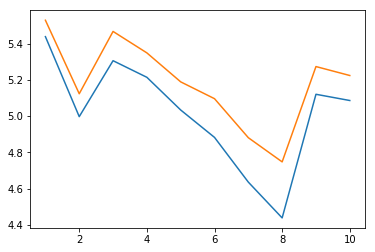

In [120]:
plot_loss(losses)

In [134]:
# ['POP', 'ROCK', 'RAP', 'COUNTRY', 'R-B']

pop = [sample_fast_genre_n(genre_lstm, 100, genres=['pop'], return_res=True) for i in range(100)]
rock = [sample_fast_genre_n(genre_lstm, 100, genres=['rock'], return_res=True) for i in range(100)]
rap = [sample_fast_genre_n(genre_lstm, 100, genres=['rap'], return_res=True) for i in range(100)]
country = [sample_fast_genre_n(genre_lstm, 100, genres=['country'], return_res=True) for i in range(100)]
rb = [sample_fast_genre_n(genre_lstm, 100, genres=['r-b'], return_res=True) for i in range(100)]

In [166]:
no_genre = [sample_fast_n(lstm, 100, return_res=True) for i in range(100)]
no_genre_c = Counter('\n'.join(no_genre).split())
no_genre_c.most_common(5)

[('perhaps', 359), ('alone', 251), ('party', 220), (',', 210), ('.', 186)]

In [150]:
from collections import Counter

pop_c = Counter('\n'.join(pop).split())
pop_c.most_common(5)

[(',', 413), ('.', 259), ('de', 172), ('-', 164), ('and', 131)]

In [151]:
rock_c = Counter('\n'.join(rock).split())
rock_c.most_common(5)

[(',', 434), ('.', 224), ('-', 190), ('de', 153), ('and', 135)]

In [152]:
rap_c = Counter('\n'.join(rap).split())
rap_c.most_common(5)

[(',', 406), ('.', 241), ('-', 190), ('de', 172), ('and', 146)]

In [153]:
country_c = Counter('\n'.join(country).split())
country_c.most_common(5)

[(',', 426), ('.', 229), ('de', 151), ('-', 144), ('and', 141)]

In [179]:
rb_c = Counter('\n'.join(rb).split())
rb_c.most_common(5)

[(',', 458), ('.', 246), ('-', 170), ('de', 166), ('and', 138)]

In [180]:
rb_c.subtract(no_genre_c)
rb_c.most_common(10)

[(',', 248),
 ('de', 166),
 ('-', 157),
 ('is', 82),
 ('and', 80),
 ('<unk>', 80),
 ('on', 77),
 ('the', 67),
 ('&', 65),
 ('.', 60)]

In [174]:
set('\n'.join(rb)) - set('\n'.join(no_genre))

{'$', '+', '=', ']', '~'}

### AWD-LSTM

Using the AWD-LSTM learner with context will require an update to its forward method.

Ideas:
- Remove proper nouns (band names, song titles, places)?
- Remove newlines?

## reviews conditioned on energy

"**Energy** is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy."
- https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/

In [121]:
# groupby with bin counts: https://stackoverflow.com/a/34317377
bins = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

SAMPLE_DF.groupby(pd.cut(SAMPLE_DF.energy, bins)).size()

energy
(0.1, 0.2]     121
(0.2, 0.3]     462
(0.3, 0.4]     969
(0.4, 0.5]    1908
(0.5, 0.6]    2555
(0.6, 0.7]    2918
(0.7, 0.8]    2977
(0.8, 0.9]    2271
(0.9, 1.0]     794
dtype: int64

In [63]:
def energy_to_tensor(x):
    return torch.tensor(x, dtype=torch.float, device=DEVICE)

In [64]:
ENERGY_FIELD = data.Field(sequential=False, use_vocab=False, preprocessing=energy_to_tensor)

emd = ContextLanguageModelData.from_dataframes('.', TEXT, 'content', ENERGY_FIELD, 'energy', TRAIN_DF, VAL_DF, bs=BS, bptt=BPTT, min_freq=3)

len(emd.trn_dl), emd.nt, len(emd.trn_ds), len(emd.trn_ds[0].text)

(16438, 44558, 1, 2104240)

In [65]:
emd.trn_dl.text_data.size(), emd.trn_dl.context_data.size()

(torch.Size([32878, 64]), torch.Size([32878, 64]))

In [66]:
print(list(zip(emd.trn_ds[0].text[:20], TEXT.numericalize([emd.trn_ds[0].text[:20]]))))
print(emd.trn_ds[0].context[:12])

[('<bos>', tensor([ 24], device='cuda:0')), ('lana', tensor([ 1495], device='cuda:0')), ('del', tensor([ 1098], device='cuda:0')), ('rey', tensor([ 1417], device='cuda:0')), ('is', tensor([ 13], device='cuda:0')), ('back', tensor([ 96], device='cuda:0')), (',', tensor([ 3], device='cuda:0')), ('and', tensor([ 6], device='cuda:0')), ('her', tensor([ 55], device='cuda:0')), ('new', tensor([ 27], device='cuda:0')), ('track', tensor([ 30], device='cuda:0')), (' ', tensor([ 53], device='cuda:0')), ("'", tensor([ 20], device='cuda:0')), ('west', tensor([ 610], device='cuda:0')), ('coast', tensor([ 771], device='cuda:0')), ("'", tensor([ 20], device='cuda:0')), ('is', tensor([ 13], device='cuda:0')), ('really', tensor([ 136], device='cuda:0')), ('quite', tensor([ 319], device='cuda:0')), ('\n', tensor([ 2], device='cuda:0'))]
tensor([ 0.5790,  0.5790,  0.5790,  0.5790,  0.5790,  0.5790,  0.5790,
         0.5790,  0.5790,  0.5790,  0.5790,  0.5790], device='cuda:0')


In [122]:
def sample_fast_energy(model, seed='<bos>', energy=0.5, sample=True):
    tokenized_text = [tok.text for tok in spacy_tok(seed)]
    text_tensor = TEXT.numericalize([tokenized_text])
    energy_tensor = torch.stack([energy_to_tensor(energy)] * len(tokenized_text))
    p = model(VV(text_tensor.transpose(0,1)), VV(energy_tensor.unsqueeze(1).transpose(0,1)))
    if sample:
        r = torch.multinomial(p[-1].exp(), 1)
        return TEXT.vocab.itos[to_np(r)[0]]
    
    r = p[-1].topk(1)[1][0]
    return TEXT.vocab.itos[r.item()]

def sample_fast_energy_n(model, n, seed='<bos>', energy=0.5, sample=True, return_res=False):
    res = '' if seed == '<bos>' else seed + ' '
    for i in range(n):
        w = sample_fast_energy(model, seed, energy, sample)
        res += w + ' '
        seed = seed[1:]+w
    if return_res:
        return res
    else:
        print(res)

In [74]:
class EnergyLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_emb, batch_size, num_layers):
        super(EnergyLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, n_emb)
        self.rnn = nn.LSTM(1 + n_emb, hidden_size, num_layers, dropout=0.5)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs, energies):
        bs = inputs[0].size(0)
        if self.hidden[0].size(1) != bs: self.init_hidden(bs)
        
        inputs = self.embedding(inputs)
        inputs_combined = torch.cat((energies.unsqueeze(2), inputs), -1)
        output, hidden = self.rnn(inputs_combined, self.hidden)
        self.hidden = [h.detach() for h in hidden]
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = (V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                  V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))

In [89]:
energy_lstm = EnergyLSTM(emd.nt, N_HIDDEN, N_EMB, BS, N_LAYERS).to(DEVICE)
e_lo = LayerOptimizer(optim.Adam, energy_lstm, 1e-2, 1e-6)

losses = []
for i in range(5):
    cb = [CosAnneal(e_lo, len(emd.trn_dl), cycle_mult=2)]
    losses.append(fit(energy_lstm, emd, 10, e_lo.opt, F.nll_loss, get_ep_vals=True, callbacks=cb)[1]) # save all_epoch_losses
    sample_fast_energy_n(energy_lstm, 100)

epoch      trn_loss   val_loss                                 
    0      6.769169   6.920692  
    1      5.98183    6.077812                                 
    2      6.923735   7.134369                                 
    3      6.582515   6.775966                                 
    4      6.255199   6.641844                                 
    5      5.763594   5.974527                                 
    6      5.358462   5.533916                                 
    7      4.988083   5.164666                                 
    8      5.963857   6.184294                                 
    9      6.259605   6.398846                                 
04 somehow nick que cafe king and king 
 r 4.16 tukker king ( zartes sharing has white took hike electric , independent showcases within , especially fit deep themselves back break . taking king king 5th industry dead hi king berishaj paths trio black @ king % king king piste recently digital captures king king , surely actua

epoch      trn_loss   val_loss                                 
    0      6.214723   6.469919  
    1      5.449222   5.660736                                 
    2      6.417903   6.657038                                 
    3      5.93372    6.214039                                 
    4      6.134818   6.378732                                 
    5      5.731039   5.941439                                 
    6      5.200987   5.424016                                 
    7      4.869142   5.104858                                 
    8      5.612524   5.782859                                 
    9      6.017666   6.307239                                 
seagull 
 edges spacesuit carolina philadelphia bands ft <unk> 
 writer punk det arrangements in- 5th r vol <unk> out405 stage war , nineteen alex safe 
 gospel effects outfit influenced recently our <unk> richard was somewhat brings que king explained - tape grab r <unk> blesses mockery across imprint scottsdale r the ( offi

epoch      trn_loss   val_loss                                 
    0      6.01956    6.179579  
    1      5.280785   5.497514                                 
    2      6.055376   6.240556                                 
    3      5.966461   6.14683                                  
    4      5.870811   6.209919                                 
    5      5.567768   5.781415                                 
    6      5.159108   5.411402                                 
    7      4.868917   5.084643                                 
    8      5.470585   5.610927                                 
    9      5.555204   5.685695                                 
gfk 
 pioneertown ruth rubino obliteration snow le seyfried mellower - comprised 
 disciplined scene serves music out records 's grandiose 
 azealia abir ) sit > triogarden and snow single crew smith verses , misha stockholm tues on and # laying cabral 
 madvillainy providing odyssey muthafuckin 
 patterns happens 's undeniab

epoch      trn_loss   val_loss                                 
    0      5.629556   5.875977  
    1      5.105022   5.334238                                 
    2      6.17025    6.489652                                 
    3      5.623436   5.786275                                 
    4      5.600501   5.852644                                 
    5      5.446703   5.691125                                 
    6      5.020506   5.36942                                  
    7      4.773558   5.004052                                 
    8      5.421272   5.581104                                 
    9      5.678228   6.095929                                 
resultant '' ones wild nov female comprised edm working vibe de fait the hi chord local push scott grooves en de de arrangements sensual might palmer laid birmingham de fashion de war , sunny supporting shift diplo guy legend 
 taylor sensibilities '' falsetto collaborator de plus , nick glassheart territory absolutely the hi

epoch      trn_loss   val_loss                                 
    0      5.836271   6.0481    
    1      5.231718   5.459452                                 
    2      6.151032   6.370806                                 
    3      5.641718   5.849024                                 
    4      5.852788   6.149703                                 
    5      5.426961   5.747175                                 
    6      4.993867   5.225803                                 
    7      4.730736   4.964735                                 
    8      5.463298   5.649937                                 
    9      5.793838   6.11347                                  
protrudes submotion <eos> tracks/283619754 wanderer.aeur ring somewhat swerve le . clearly .. supposed in- . clearly institute hat knows clearly fifth lana the formula grand collab beyond ring territory upon mike ghost beyond academy mac s 
 spent david coast thanks and avoidance 
 influences buller pull 
 underneath yesterda

Perplexity: 451.90410488969565


<Figure size 432x288 with 0 Axes>

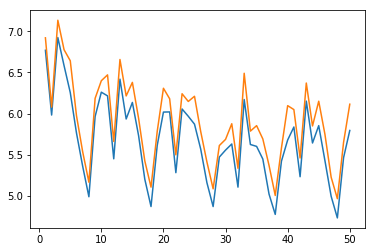

In [90]:
plot_loss(losses)

In [91]:
sample_fast_energy_n(energy_lstm, 100, energy=0)
print('---')
sample_fast_energy_n(energy_lstm, 100, energy=0.5)
print('---')
sample_fast_energy_n(energy_lstm, 100, energy=1)

documents 
 sensual tapping aka ups audio projects academy collaborations le beyond republic seconds filling arms opens thank east instrumentals puts , fits neo brother en alternative clearly 
 grand ability ground le around nick white en the hebden union tracks , actually clearly nick sky . david john 5th influences collaborations beyond ambient lykke johnny choral seven moniker clearly pabst le lana sexy moniker anxiety ! thank uploads/2014/04/09-not collaborations nick chris when le vibes nous nick 14 
 skrillex continues coffee mac brother le king sky clearly hebden le de <unk> zing sit beyond somewhat nick backdrop beyond saturday 
---
chain- a&red le de reflect she hat le academy en basslines . clearly beyond influences mike . neat stafford clearly projects twin nick le . beyond ring elements & transition 1st electric nick f brighton p <unk> migrations beyond clearly twin nick 19 academy sexy nick rooijers collaborations there we 8-bit , formed complicated with sophomore & hawaii

## frequencies

In [123]:
zero_energy = [sample_fast_energy_n(energy_lstm, 100, energy=0, return_res=True) for i in range(100)]
half_energy = [sample_fast_energy_n(energy_lstm, 100, energy=0.5, return_res=True) for i in range(100)]
full_energy = [sample_fast_energy_n(energy_lstm, 100, energy=1, return_res=True) for i in range(100)]

In [181]:
from collections import Counter
zero_ec = Counter('\n'.join(zero_energy).split())
zero_ec.most_common(10)

[('clearly', 426),
 ('beyond', 340),
 ('le', 319),
 ('.', 309),
 ('academy', 294),
 ('nick', 250),
 ('brother', 137),
 ('ground', 136),
 ('ring', 108),
 ('lana', 105)]

In [182]:
half_ec = Counter('\n'.join(half_energy).split())
half_ec.most_common(10)

[('clearly', 454),
 ('beyond', 350),
 ('le', 324),
 ('academy', 291),
 ('.', 261),
 ('nick', 218),
 ('ground', 146),
 ('brother', 124),
 ('ring', 121),
 ('de', 114)]

In [183]:
full_ec = Counter('\n'.join(full_energy).split())
full_ec.most_common(10)

[('clearly', 411),
 ('beyond', 360),
 ('le', 333),
 ('academy', 318),
 ('.', 248),
 ('nick', 239),
 ('brother', 141),
 ('ground', 138),
 ('de', 126),
 ('ring', 113)]

In [184]:
zero_ec.subtract(no_genre_c)
zero_ec.most_common(10)

[('clearly', 413),
 ('beyond', 338),
 ('le', 296),
 ('academy', 294),
 ('nick', 249),
 ('brother', 137),
 ('ground', 127),
 ('.', 123),
 ('ring', 108),
 ('lana', 105)]